Combining multiple cos files into what will go into the SED. Also fitting T1.

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import astropy.io.fits as fits
import os
from scipy.io.idl import readsav
from astropy.table import Table, vstack
from astropy.io import ascii
import astropy.units as u
import astropy.constants as const
from astropy.modeling import models, fitting
from craftroom import resample
from scipy.interpolate import interp1d
from astropy.convolution import convolve, Box1DKernel


%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [3]:
cospath = 'test_files/'
cosfits = glob.glob(cospath+'*.ecsv')
cosfits

['test_files/hlsp_muscles_hst_cos_2mass-j23062928-0502285_g160m_v1_component-spec.ecsv',
 'test_files/hlsp_muscles_hst_cos_2mass-j23062928-0502285_g130m_v1_component-spec.ecsv']

Lya and OI airglow- have to do this by eye.

['test_files/hlsp_muscles_hst_cos_2mass-j23062928-0502285_g160m_v1_component-spec.ecsv']


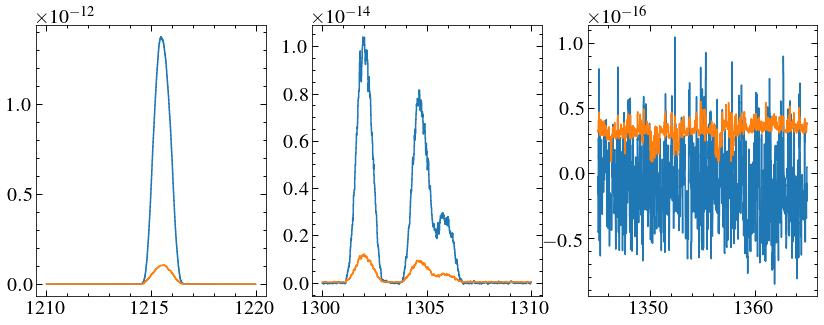

In [71]:
def boxcar_with_error(f, e, factor):
    f_smooth = convolve(f,Box1DKernel(factor))
    e_smooth = convolve(e,Box1DKernel(factor))/factor**0.5
    return f_smooth, e_smooth
 


#lya_edges = [1207, 1225] #lyman alpha region to remove
#airglow = [1301, 1307, 1355, 1356]
g130m = glob.glob(cospath+'*g130m*.ecsv')
g160m = glob.glob(cospath+'*g160m*.ecsv')
print(g160m)

def airglow_inspect(g130m):
    data = Table.read(g130m)
    w, f, e = data['WAVELENGTH'],data['FLUX'], data['ERROR']
    f,e  = boxcar_with_error(f,e,5)
    airglow_ranges = [[1210, 1220], [1300, 1310], [1345, 1365]]
    for i in range(len(airglow_ranges)):
        plt.subplot(1,3, i+1)
        mask = (w > airglow_ranges[i][0]) & (w < airglow_ranges[i][1])
        plt.step(w[mask], f[mask], where='mid')
        plt.step(w[mask], e[mask], where='mid')

airglow_inspect(g130m[0])

In [30]:
lya = [1214, 1217]
oi = [1301, 1307]
airglow = lya + oi

In [19]:
def cont_masker( x, b,r ):
    """
    creates a mask for a spectrum that regions between pairs from a file
    """
    C = np.zeros_like(x,dtype='bool')
    for i in range(len(b)):
        C |= (x>b[i])&(x<r[i])
    return ~C

In [29]:
lines = lya+oi
print(lines)

[1214, 1217, 1301, 1307]


In [62]:
import instruments

def mask_maker(x, pairs, include=True):
    """
    creates a mask for a spectrum that excudes between pairs from an array
    """
    b = pairs[::2]
    r = pairs[1::2]
    C = np.zeros_like(x,dtype='bool')
    for i in range(len(b)):
        C |= (x>b[i])&(x<r[i])
    if include:
        return ~C
    else:
        return C

def hst_instrument_column(table):
    """
    Builds an instrument column and adds it to data. For HST data.
    """
    telescope, instrument, grating = table.meta['TELESCOP'], table.meta['INSTRUME'], table.meta['GRATING']
    if instrument == 'STIS':
        instrument = 'sts'
    inst_string = '%s_%s_%s' % (telescope.lower(), instrument.lower(), grating.lower())
    inst_code = instruments.getinsti(inst_string)
    inst_array = np.full(len(table['WAVELENGTH']), inst_code, dtype=int)
    table['INSTRUMENT'] = inst_array
    return inst_code, table

def build_cos_fuv(cospath, airglow):
    instrument_list = [] #starts a running count of all instruments
    g130m_path = glob.glob(cospath+'*g130m*.ecsv')[0]
    g160m_path = glob.glob(cospath+'*g160m*.ecsv')[0]
    g130m = Table.read(g130m_path)
    instrument_code, g130m = hst_instrument_column(g130m)
    instrument_list.append(instrument_code)
    airglow_mask = mask_maker(g130m ['WAVELENGTH'], airglow)
    sed_table = g130m[airglow_mask] #start the full SED table
    
    if len(g160m_path) > 0:
        g160m = Table.read(g160m_path)
        instrument_code, g160m = hst_instrument_column(g160m)
        instrument_list.append(instrument_code)
        g160m = g160m[g160m['WAVELENGTH'] > sed_table['WAVELENGTH'][-1]] #cut off everything covered by g130m
        #sed_table = sed_table+g130m
        #[sed_table.add_row(row) for row in g160m]
        sed_table = vstack([sed_table, g160m], metadata_conflicts = 'silent')
    
    return sed_table, instrument_list

lya = [1212, 1219]
oi = [1301, 1307]
airglow = lya + oi

cos_table, instrument_list = build_cos_fuv(cospath, airglow)

In [63]:
w, f, e = cos_table['WAVELENGTH'], cos_table['FLUX'], cos_table['ERROR']

In [64]:
def boxcar_with_error(f, e, factor):
    f_smooth = convolve(f,Box1DKernel(factor))
    e_smooth = convolve(e,Box1DKernel(factor))/factor**0.5
    return f_smooth, e_smooth
 

fb, eb = boxcar_with_error(f,e, 5)

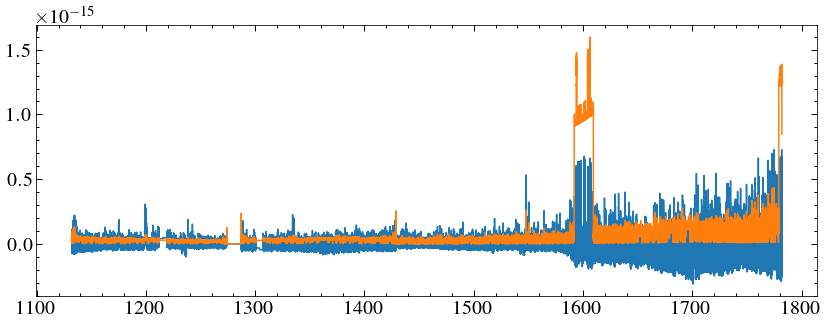

In [66]:
plt.step(w, fb, where='mid')
plt.step(w, eb, where='mid')


In [67]:
instrument_list

[1, 2]

Ok that worked, looks like we have a format!

Fitting. First let's get rid of that masssive error blip at 1600.

/home/david/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/home/david/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
/home/david/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.


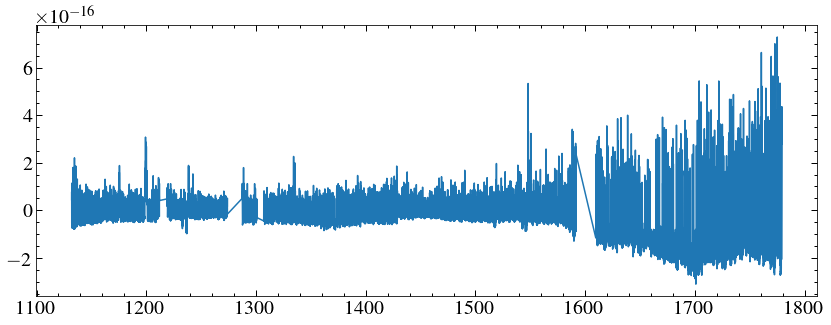

In [96]:
#plt.plot(w, abs(f)/e)
#plt.xlim(1580, 1620)
#plt.ylim(0, 1)
mask = abs(fb)/eb > 1
plt.plot(w[mask], fb[mask])
wi, fi, ei = w[mask], fb[mask], eb[mask] 

Model: Polynomial1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Degree: 1
Parameters:
              c0                     c1          
    --------------------- -----------------------
    1.614043098177374e-16 -1.2459705065684277e-19


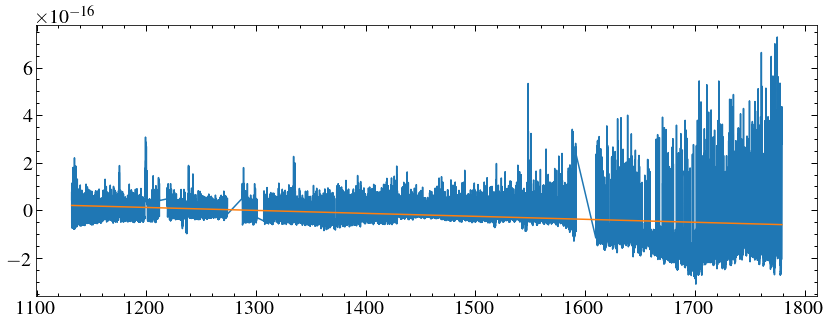

In [100]:
fitter = fitting.LinearLSQFitter()
n_init = models.Polynomial1D(1)
n_fit = fitter(n_init, wi, fi)
plt.plot(wi, fi)
plt.plot(wi, n_fit(wi))
print(n_fit)

In [109]:
ciii_1175 = [1174.93,1175.26,1175.59,1175.71,1175.99]
feii_1200 =[1199.231,1199.681,1200.889]
siiii_1206 = [1206.51, 1206.53]
nv_1240 = [1238.821, 1242.804]
ci_1288 = [1288.918]
feii_1292 = [1292.405]
cii_1335 = [1334.532, 1335.708]
feii_1527 = [1527.2397] 
civ_1550 = [1548.202,1550.774]
mgii_2800 = [2795.528]


all_lines = ciii_1175 + feii_1200 + siiii_1206 + [nv_1240[0]] + [nv_1240[1]] + ci_1288 + [cii_1335[0]] + [cii_1335[1]] + feii_1527 + [civ_1550[0]] + [civ_1550[1]] #+ mgii_2800
#all_lines = [ciii_1175, feii_1200, siiii_1206, [nv_1240[0]], [nv_1240[1]], ci_1288, [cii_1335[0]],[cii_1335[1]], feii_1527, [civ_1550[0]],[civ_1550[1]], mgii_2800]
print(all_lines)

dv = -56300 #Bourrier+17a 
c = const.c.value
dshift = (1.0+(dv/c))

[1174.93, 1175.26, 1175.59, 1175.71, 1175.99, 1199.231, 1199.681, 1200.889, 1206.51, 1206.53, 1238.821, 1242.804, 1288.918, 1334.532, 1335.708, 1527.2397, 1548.202, 1550.774]


In [121]:
model_init = models.Linear1D(intercept=-1e-17)# n_init
for line in all_lines:
    model_init = model_init + models.Gaussian1D(1e-16, line*dshift, 0.5)
    

In [122]:
#plt.plot(wi, model_init(wi))
fitter = fitting.SLSQPLSQFitter()
model_fit = fitter(model_init, wi, fi, maxiter=10000)

Inequality constraints incompatible    (Exit mode 4)
            Current function value: 9121529602.072485
            Iterations: 3
            Function evaluations: 184
            Gradient evaluations: 3


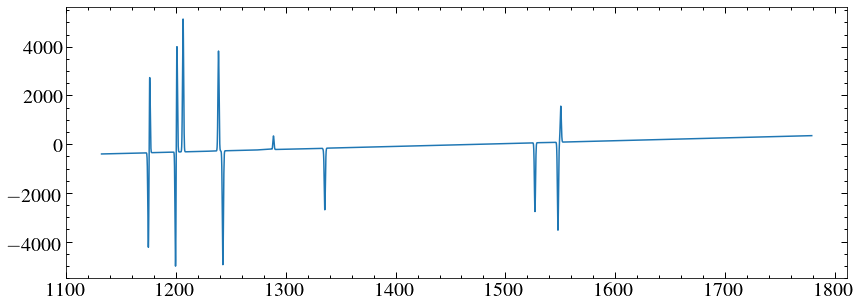

In [123]:
plt.plot(wi, model_fit(wi))